In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

from iq_mixer import IQMixer
from cic3d128 import CIC3D128
from seq_fir import FIR
from cordic_atan2 import CAtan2
from common import width_convert

In [96]:
def plot_spectrum(sample_rate, signal, title, zoom = False, zoomed_c_freq=None, zoomed_span=None):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sample_rate)
    xf = fftshift(xf)
    yf = fftshift(yf)

    magnitude = 2.0 / N * np.abs(yf)

    if zoom:
        fig, axes = plt.subplots(2, 1, figsize=(6, 6))

        # full spectrum
        axes[0].plot(xf, magnitude)
        axes[0].set_title(f'{title} - Full Spectrum')
        axes[0].set_xlabel('Frequency (Hz)')
        axes[0].set_ylabel('Magnitude')
        axes[0].grid(True)
        # zoomed spectrum

        center_freq = zoomed_c_freq
        span = zoomed_span
        mask = (xf >= center_freq - span / 2) & (xf <= center_freq + span / 2)
        axes[1].plot(xf[mask], magnitude[mask])
        axes[1].set_title(f'{title} - Zoomed Spectrum around {center_freq/1e6} MHz (±{span/2/1e6} MHz)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('Magnitude')
        axes[1].grid(True)
        # set x to 10 ticks centered at center_freq
        axes[1].set_xticks(np.arange(center_freq - span/2, center_freq + span/2 + 1, span / 10))

    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 3))
        # full spectrum
        axes.plot(xf, magnitude)
        axes.set_title(f'{title} - Full Spectrum')
        axes.set_xlabel('Frequency (Hz)')
        axes.set_ylabel('Magnitude')
        axes.grid(True)

    fig.tight_layout()
    
    return fig, axes


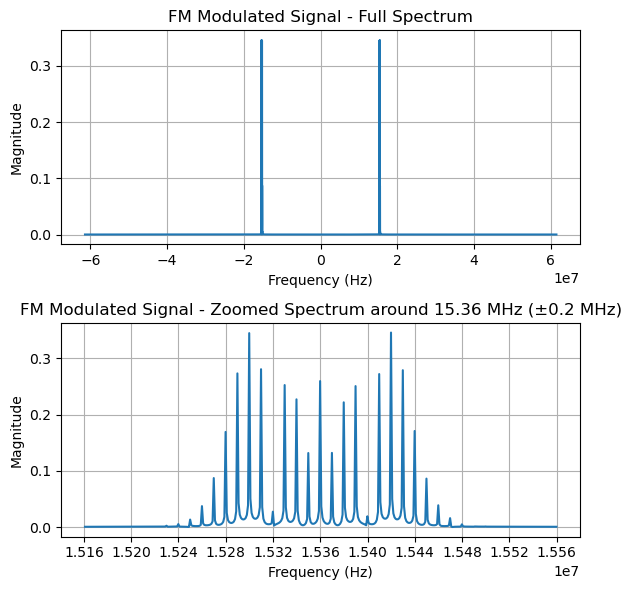

In [97]:
sample_rate = 122.88e6

# read fm modulated data from CSV file
input = np.loadtxt("fm_10k_75k_15_36M.csv", delimiter=",", dtype=np.float64)

_, _ = plot_spectrum(sample_rate, input, "FM Modulated Signal", zoom=True, zoomed_c_freq=15.36e6, zoomed_span=4e5)


In [98]:
#convert input to 16bits 2'complement in uint16 format
input_uint16 = np.clip(np.round(input * 32767), -32768, 32767).astype(np.int16).astype(np.uint16)

# mixed iq signal traces
mixed_output_i = np.zeros_like(input_uint16, dtype=np.uint16)
mixed_output_q = np.zeros_like(input_uint16, dtype=np.uint16)

# cic decimated output traces
decimated_output_i = np.zeros(len(input_uint16), dtype=np.uint64)
decimated_output_q = np.zeros(len(input_uint16), dtype=np.uint64)
decimated_output_i_valid = np.zeros(len(input_uint16), dtype=bool)
decimated_output_q_valid = np.zeros(len(input_uint16), dtype=bool)

# cic compensation fir filter traces
fir_output_i = np.zeros(len(input_uint16), dtype=np.uint64)
fir_output_i_valid = np.zeros(len(input_uint16), dtype=bool)
fir_output_q = np.zeros(len(input_uint16), dtype=np.uint64)
fir_output_q_valid = np.zeros(len(input_uint16), dtype=bool)

# atan2 output traces
atan2_output = np.zeros(len(input_uint16), dtype=np.uint32)
atan2_output_valid = np.zeros(len(input_uint16), dtype=bool)

# create iq mixer instance
mixer = IQMixer(exec_path="../../build/exec/iq_mixer", freq=15.36e6, sample_rate=sample_rate, silent=True)

# create cic decimator instance
cic_decimator_i = CIC3D128(exec_path="../../build/exec/cic3d128", silent=True)
cic_decimator_q = CIC3D128(exec_path="../../build/exec/cic3d128", silent=True)

# create fir filter instance
fir_filter_i = FIR(exec_path="../../build/exec/cic3d128comp", silent=True)
fir_filter_q = FIR(exec_path="../../build/exec/cic3d128comp", silent=True)

# create cordic atan2 instance
cordic_atan2 = CAtan2(exec_path="../../build/exec/atan2", silent=True)

try:
    for idx, sample in enumerate(input_uint16):
        i, q = mixer.forward(sample)
        valid_i, dec_i = cic_decimator_i.forward(i)
        valid_q, dec_q = cic_decimator_q.forward(q)
        
        # convert 37-bit cic output to 18-bit fir input
        dec_i_18 = width_convert(dec_i, from_bits=37, to_bits=18)
        dec_q_18 = width_convert(dec_q, from_bits=37, to_bits=18)
        # to np.uint32
        dec_i_18 = np.uint32(dec_i_18 & np.uint64(0xFFFFFFFF))
        dec_q_18 = np.uint32(dec_q_18 & np.uint64(0xFFFFFFFF))
        
        valid_fir_i, fir_i = fir_filter_i.forward(valid_i, dec_i_18)
        valid_fir_q, fir_q = fir_filter_q.forward(valid_q, dec_q_18)

        #  get the lower (36:4] bits of fir output as cordic input
        fir_i_32 = np.uint32((fir_i >> np.uint64(4)) & np.uint64(0xFFFFFFFF))
        fir_q_32 = np.uint32((fir_q >> np.uint64(4)) & np.uint64(0xFFFFFFFF))

        valid_atan2, atan2_res = cordic_atan2.forward(valid_fir_i and valid_fir_q, fir_q_32, fir_i_32)
        
        mixed_output_i[idx] = i
        mixed_output_q[idx] = q
        decimated_output_i[idx] = dec_i
        decimated_output_q[idx] = dec_q
        decimated_output_i_valid[idx] = valid_i
        decimated_output_q_valid[idx] = valid_q
        fir_output_i[idx] = fir_i
        fir_output_q[idx] = fir_q
        fir_output_i_valid[idx] = valid_fir_i
        fir_output_q_valid[idx] = valid_fir_q
        atan2_output[idx] = atan2_res
        atan2_output_valid[idx] = valid_atan2

finally:
    mixer.terminate()
    cic_decimator_i.terminate()
    cic_decimator_q.terminate()
    fir_filter_i.terminate()
    fir_filter_q.terminate()
    cordic_atan2.terminate()

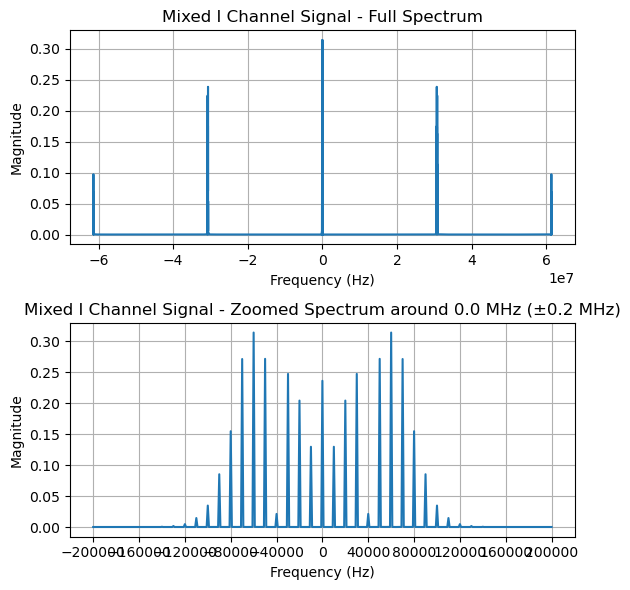

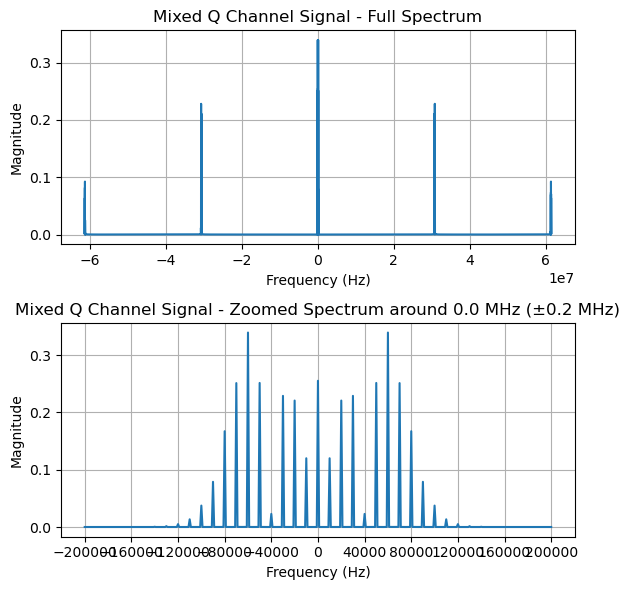

In [99]:
# convert iq outputs back to float32
mixed_output_i_float = (mixed_output_i.astype(np.int16).astype(np.float32)) / 32768.0
mixed_output_q_float = (mixed_output_q.astype(np.int16).astype(np.float32)) / 32768.0

_, _ = plot_spectrum(sample_rate, mixed_output_i_float, "Mixed I Channel Signal", zoom=True, zoomed_c_freq=0, zoomed_span=4e5)
_, _ = plot_spectrum(sample_rate, mixed_output_q_float, "Mixed Q Channel Signal", zoom=True, zoomed_c_freq=0, zoomed_span=4e5)


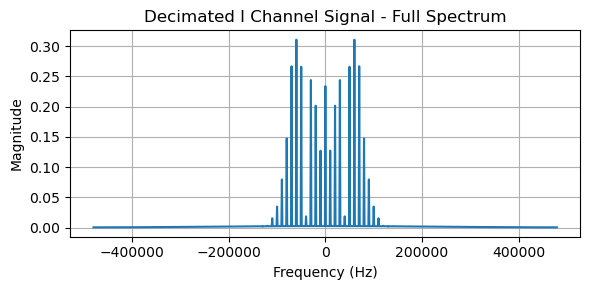

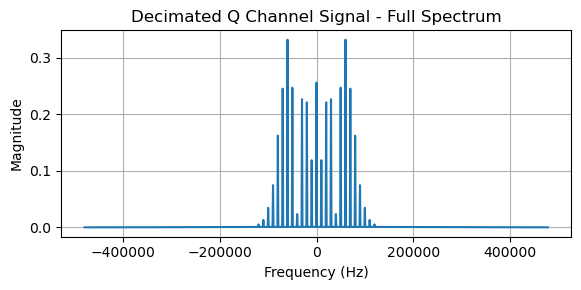

In [100]:
#keep only valid decimated outputs
decimated_output_i_filtered = decimated_output_i[decimated_output_i_valid]
decimated_output_q_filtered = decimated_output_q[decimated_output_q_valid]

# convert cic outputs (37bits signed) back to float32
decimated_output_i_float = (decimated_output_i_filtered.astype(np.int64).astype(np.float32)) / (2**36)
decimated_output_q_float = (decimated_output_q_filtered.astype(np.int64).astype(np.float32)) / (2**36)

_, _ = plot_spectrum(sample_rate / 128, decimated_output_i_float, "Decimated I Channel Signal")
_, _ = plot_spectrum(sample_rate / 128, decimated_output_q_float, "Decimated Q Channel Signal")


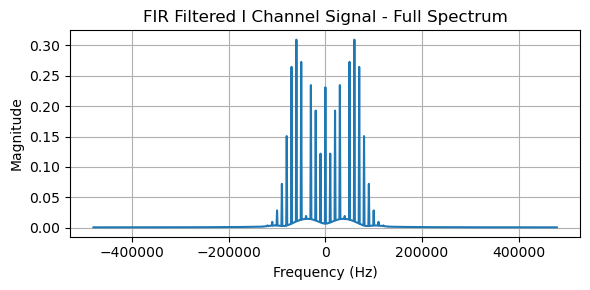

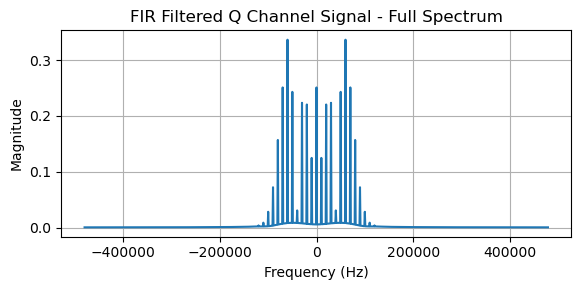

In [101]:
# keep only valid fir outputs
fir_output_i_filtered = fir_output_i[fir_output_i_valid]
fir_output_q_filtered = fir_output_q[fir_output_q_valid]

# convert fir outputs (48bits signed) back to float32
fir_output_i_float = (fir_output_i_filtered.astype(np.int64).astype(np.float32)) / (2**34)
fir_output_q_float = (fir_output_q_filtered.astype(np.int64).astype(np.float32)) / (2**34)

_, _ = plot_spectrum(sample_rate / 128, fir_output_i_float, "FIR Filtered I Channel Signal")
_, _ = plot_spectrum(sample_rate / 128, fir_output_q_float, "FIR Filtered Q Channel Signal")

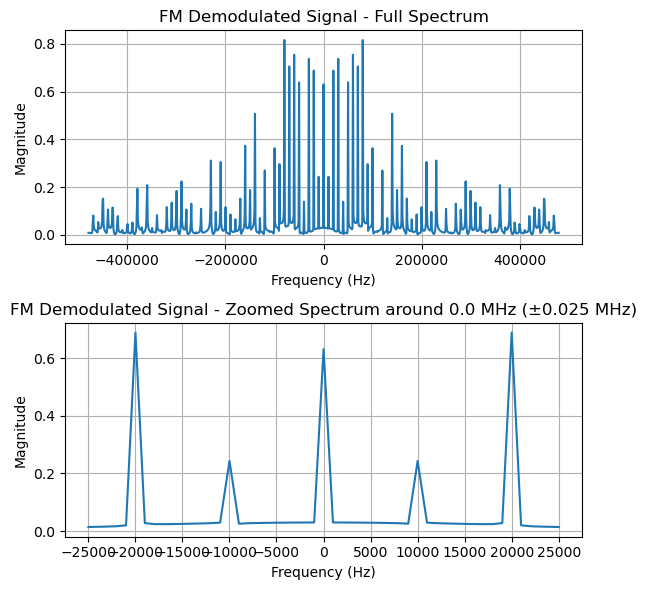

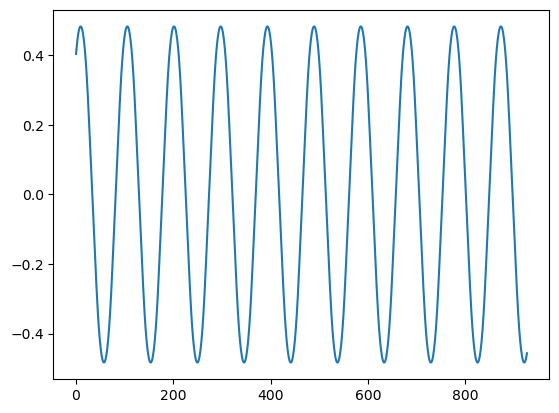

In [105]:
# convert atan2 outputs back to float32
atan2_output_filtered = atan2_output[atan2_output_valid]
atan2_output_float = (atan2_output_filtered.astype(np.int32).astype(np.float32)) / (2**29)

_, _ = plot_spectrum(sample_rate / 128, (atan2_output_float), "FM Demodulated Signal", zoom=True, zoomed_c_freq=0, zoomed_span=50e3)

plt.figure()
plt.plot(np.unwrap(atan2_output_float[33:]) - np.unwrap(atan2_output_float[32:-1]))


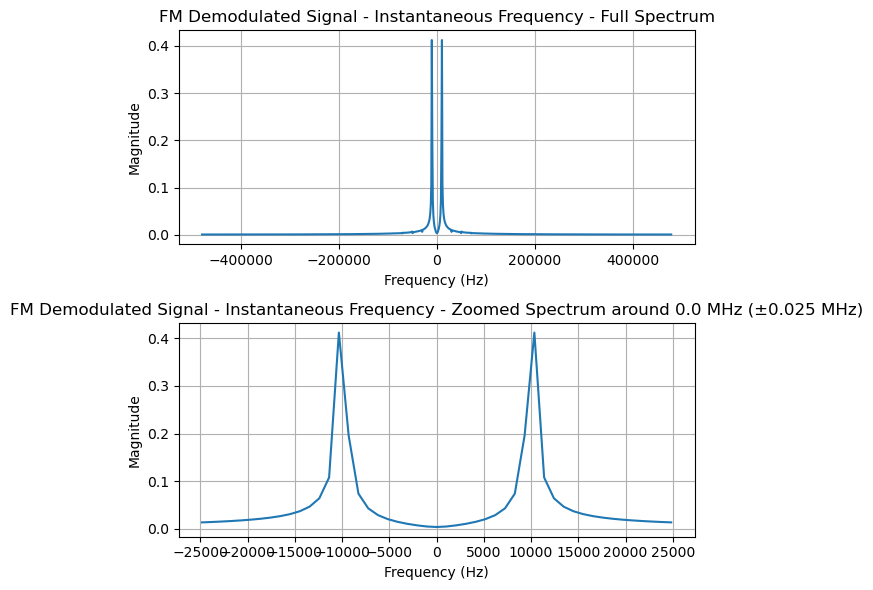

In [106]:
_, _ = plot_spectrum(sample_rate / 128, np.unwrap(atan2_output_float[33:]) -np.unwrap(atan2_output_float[32:-1]), "FM Demodulated Signal - Instantaneous Frequency", zoom=True, zoomed_c_freq=0, zoomed_span=50e3)